In [2]:
from collections import Counter, defaultdict
import gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import Word2VecVocab
import math 
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot
from numpy.linalg import norm
from numpy.random import permutation
import operator
import os
from os import listdir
import pandas as pd
import pylab
from scipy.stats import pearsonr 
import seaborn as sns
import sklearn.metrics.pairwise
from statistics import mean, stdev
import statsmodels.api as sm
import string
import sys
import time
from zipfile import ZipFile 
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!
from __future__ import division
import cython
import pickle
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from itertools import combinations
import random
import geopandas
import json
from shapely.geometry import Point
#import pywren

def norm(a):
    row_sums = a.sum(axis=1)
    new_matrix = a / row_sums[:, np.newaxis]
    return new_matrix

def flushPrint(d): # counter
    sys.stdout.write('\r')
    sys.stdout.write(str(d))
    sys.stdout.flush()

### 1. year, socName, N posts, ave. pay, ave. edu

#### Extract year, socName, N posts, ave. pay, ave. edu from raw main data

In [ ]:
start = time.clock()
for i in range(2010, 2020):
    year = str(i)
    folder = '/project2/jevans/BG/Structured_Data/Main/' + year + '/'
    for f in listdir(folder):
        if not f.startswith('.'):
            print(f)
#             try:
#             # unzip and read each file into dataframe
#                 with ZipFile(folder+f) as z:
#                     with z.open(f.split('.')[0]+'.txt') as f1:
#                         df = pd.read_csv(f1,header='infer', delimiter="\t", encoding="ISO-8859-1", low_memory=False)
#             except:
#                 # dealing with the broken file separately
#                 df = pd.read_csv('/project2/jevans/ditong/BG/Main_2011-04.txt', 
#                      delimiter="\t", header='infer',encoding = "ISO-8859-1", low_memory=False) 
            with ZipFile(folder+f) as z:
                with z.open(f.split('.')[0]+'.txt') as f1:
                    df = pd.read_csv(f1,header='infer',delimiter="\t",encoding = "ISO-8859-1", low_memory=False)
                    for a,b,c,d,e,f,g,h,i,j,k in zip(df['BGTJobId'],df['JobDate'],df['CleanTitle'],df['SOCName'],
                                    df['MinSalary'], df['MaxSalary'], df['Edu'], df['MaxEdu'],
                                    df['JobHours'], df['TaxTerm'], df['Internship']): 
                        line1 = "\t".join([str(a), str(c)])
                        line2 = "\t".join([str(a), str(b), str(d), str(e)+'_'+str(f), str(g)+'_'+str(h), 
                                           str(i), str(j), str(k)])
                        with open('/project2/jevans/ditong/data/SOC/jobid_date_soc_pay_edu_fullPartTime_employeeContractor_internOrNot.txt', 
                                  'w') as f2:
                            f2.write(line2 + "\n")
                    
elapsed = (time.clock() - start)

#### Produce year- socName, Nposts, pay list, education dictionaries; year-socName-jobPostId

In [7]:
#start = time.clock()
yjn = defaultdict(lambda:defaultdict(lambda:0))
yjpl = defaultdict(lambda:defaultdict(lambda:[]))
yjel = defaultdict(lambda:defaultdict(lambda:[]))
yjmaxel = defaultdict(lambda:defaultdict(lambda:[]))
yjmedel = defaultdict(lambda:defaultdict(lambda:[]))
n=0
dic_job_id = defaultdict(lambda:set())
with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/jobid_date_soc_pay_edu_fullPartTime_employeeContractor_internOrNot.txt',
          'r') as f:
    for line in f:
        n+=1
        if n>1000000 and n % 1000000 == 0:
            flushPrint(n/1000000)
        line_lst = line.split('\t')
        jobid = line_lst[0]
        year = int(line_lst[1][:4])
        soc = line_lst[2]
        pay = line_lst[3]
        edu = line_lst[4]
        #jobhours = line_lst[5]
        #taxterm = line_lst[6]  
        #intern = int(line_lst[7])
        if soc not in ['na', 'nan']:
            # count occupation job post number
            yjn[year][soc] += 1
            
            # list of median pay
            minp, maxp=[float(num) for num in pay.split("_")]
            if minp >0 and maxp > 0:
                medp = minp + (maxp - minp) / 2
                yjpl[year][soc].append(medp)
            
            # list of min education
            mine, maxe=[float(num) for num in edu.split("_")]
            if mine >0:
                yjel[year][soc].append(mine)
            if maxe >0:
                yjmaxel[year][soc].append(maxe)
                if mine > 0:
                    mede = mine + (maxe - mine) / 2
                    yjmedel[year][soc].append(mede)
                
            # socName-jobid
            dic_job_id[soc].add(jobid)
            
#elapsed = (time.clock() - start)  

187.0

In [8]:
yje = defaultdict(lambda:defaultdict(lambda:0))
yjmaxe = defaultdict(lambda:defaultdict(lambda:0))
yjmede = defaultdict(lambda:defaultdict(lambda:0))
yjp = defaultdict(lambda:defaultdict(lambda:0))
jye = defaultdict(lambda:defaultdict(lambda:0))
jyp = defaultdict(lambda:defaultdict(lambda:0))
for year in range(2010, 2020):
    for job in yjel[year]:
        yje[year][job] = mean(yjel[year][job])
        jye[job][year] = yje[year][job]
    for job in yjmaxel[year]:
        yjmaxe[year][job] = mean(yjmaxel[year][job])
        #jye[job][year] = yje[year][job]
    for job in yjmedel[year]:
        yjmede[year][job] = mean(yjmedel[year][job])
        #jye[job][year] = yje[year][job]
    for job in yjpl[year]:
        yjp[year][job] = mean(yjpl[year][job])
        jyp[job][year] = yjp[year][job]

In [9]:
len(yjn), len(yje), len(yjp), len(yjmaxe), len(yjmede)

(10, 10, 10, 10, 10)

In [10]:
# min education, max education, median education
with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/year_socName_aveMinEdu_avgMaxEdu_avgMedEdu.txt',
          'w') as f:
    for year in yje:
        for job in yje[year]:
            if job in yjmaxe[year]:
                if job in yjmede[year]:
                    line = "\t".join([str(year), job, str(yje[year][job]), str(yjmaxe[year][job]), str(yjmede[year][job])])
                else:
                    line = "\t".join([str(year), job, str(yje[year][job]), str(yjmaxe[year][job]), 'nan'])
            else:
                if job in yjmede[year]:
                    line = "\t".join([str(year), job, str(yje[year][job]), 'nan', str(yjmede[year][job])])
                else:
                    line = "\t".join([str(year), job, str(yje[year][job]), 'nan', 'nan'])
            f.write(line + "\n")

In [19]:
with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/year_socName_Nposts_aveMedianPay_aveMinEdu.txt',
          'w') as f:
    for year in yjn:
        for job in yjn[year]:
            if job in yje[year]:
                if job in yjp[year]:
                    line = "\t".join([str(year), job, str(yjn[year][job]), str(yje[year][job]), str(yjp[year][job])])
                else:
                    line = "\t".join([str(year), job, str(yjn[year][job]), str(yje[year][job]), 'nan'])
            else:
                if job in yjp[year]:
                    line = "\t".join([str(year), job, str(yjn[year][job]), 'nan', str(yjp[year][job])])
                else:
                    line = "\t".join([str(year), job, str(yjn[year][job]), 'nan', 'nan'])
            f.write(line + "\n")

In [ ]:
with open('/project2/jevans/ditong/data/SOC/' + year + '/' + year + '_job_id.txt', 'w') as f:
    for job in dic_job_id:
        ids = "_".join(list(dic_job_id[job]))
        line = "\t".join([job, ids])
        f.write(line + "\n")

### 2. job - meta (ave. pay, ave. edu, 2-digits soc)

#### Read in BLS Data

In [20]:
# BLS 2010, 2018 Occupational employment volume, 2018 pay
df_2018=pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/Data/raw/national_M2018_dl.xlsx')
ocg={}
cg = {}
for i, j, k in zip(df_2018['OCC_TITLE'], df_2018['OCC_GROUP'], df_2018['OCC_CODE']):
    if j=='major':
        cg[k[:2]] = i
    elif j == 'detailed':
        ocg[i] = cg[k[:2]]

In [23]:
ocg['Adult Basic and Secondary Education and Literacy Teachers and Instructors '] = 'Education, Training, and Library Occupations'
ocg['Assemblers and Fabricators, All Other'] = 'Production Occupations'
ocg['Bus Drivers, School or Special Client '] = 'Transportation and Material Moving Occupations'
ocg['Bus Drivers, Transit and Intercity '] = 'Transportation and Material Moving Occupations'
ocg['Buyers and Purchasing Agents, Farm Products'] = 'Business and Financial Operations Occupations'
ocg['Construction and Related Workers, All Other'] = 'Construction and Extraction Occupations'
ocg['Electrical and Electronic Equipment Assemblers'] = 'Production Occupations'
ocg['Electromechanical Equipment Assemblers'] = 'Production Occupations'
ocg['First-Line Supervisors of Helpers, Laborers, and Material Movers, Hand'] = 'Transportation and Material Moving Occupations'
ocg['First-Line Supervisors of Transportation and Material-Moving Machine and Vehicle Operators'] = 'Transportation and Material Moving Occupations'
ocg['Fishers and Related Fishing Workers'] = 'Farming, Fishing, and Forestry Occupations'
ocg['Gaming Supervisors'] = 'Personal Care and Service Occupations'
ocg['Health Educators '] = 'Community and Social Service Occupations'
ocg['Hunters and Trappers'] = 'Farming, Fishing, and Forestry Occupations'
ocg['Mathematical Science Occupations, All Other'] = 'Computer and Mathematical Occupations'
ocg['Medical and Clinical Laboratory Technicians'] = 'Healthcare Practitioners and Technical Occupations'
ocg['Medical and Clinical Laboratory Technologists'] = 'Healthcare Practitioners and Technical Occupations'
ocg['Mental Health Counselors'] = 'Community and Social Service Occupations'
ocg['Purchasing Agents, Except Wholesale, Retail, and Farm Products'] = 'Business and Financial Operations Occupations'
ocg['Radio, Cellular, and Tower Equipment Installers and Repairs'] = 'Installation, Maintenance, and Repair Occupations'
ocg['Radiologic Technologists '] = 'Healthcare Practitioners and Technical Occupations'
ocg['Segmental Pavers'] = 'Construction and Extraction Occupations'
ocg['Slot Supervisors'] = 'Personal Care and Service Occupations'
ocg['Substance Abuse and Behavioral Disorder Counselors'] = 'Community and Social Service Occupations'
ocg['Teachers and Instructors, All Other'] = 'Education, Training, and Library Occupations'
ocg['Team Assemblers'] = 'Production Occupations'
ocg['Tour Guides and Escorts'] = 'Personal Care and Service Occupations'
ocg['Transportation Attendants, Except Flight Attendants '] = 'Transportation and Material Moving Occupations'
ocg['Travel Guides'] = 'Personal Care and Service Occupations'
ocg['Wholesale and Retail Buyers, Except Farm Products'] = 'Business and Financial Operations Occupations'

In [25]:
# get annual average education level for each occupation
oe = {}
for job in jye:
    oe[job] = np.mean([jye[job][yr] for yr in jye[job] if yr != 2019])
# get annual average pay level for each occupation
op = {}
for job in jyp:
    op[job] = np.mean([jyp[job][yr] for yr in jyp[job] if yr != 2019])

In [28]:
len(oe), len(op), len(ocg)

(834, 835, 838)

In [29]:
with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/socName_aveMedianPay_aveMinEdu_socGroup.txt','w') as f:
    for job in ocg:
        if job in oe:
            if job in op:
                line = "\t".join([job, str(op[job]), str(oe[job]), str(ocg[job])])
            else:
                line = "\t".join([job, 'nan', str(oe[job]), str(ocg[job])])
        else:
            if job in op:
                line = "\t".join([job, str(op[job]), 'nan', str(ocg[job])])
            else:
                line = "\t".join([job, 'nan', 'nan', str(ocg[job])])
        f.write(line + "\n")

### 3. year -company - N posts; 4a, 4b year - socName - skill freq for large and small company

#### Extract for each year: socName, jobid, employer from Raw Main Data

In [ ]:
for yr in [2007, 2010, 2018, 2019]:
    year = str(yr)
    with open('/project2/jevans/ditong/data/SOC/'+year+'/'+year+'_jobid_employer.txt','w') as f:
        pass
    folder = '/project2/jevans/BG/Structured_Data/Main/' + year + '/'
    for f in listdir(folder):
        if not f.startswith('.'):
            print(f)
            with ZipFile(folder+f) as z:
                with z.open(f.split('.')[0]+'.txt') as f1:
                    df = pd.read_csv(f1,header='infer',delimiter="\t", encoding = "ISO-8859-1", low_memory=False)
                    for a,b,c,d in zip(df['BGTJobId'],df['Employer'], df['SOCName'], df['MSA']): 
                        if b[-1] == '\xa0':
                            b = b[:-1]
                        if b != 'na' and c != 'na' and d != -999:
                            line = "\t".join([str(a), str(b), str(c)])
                        with open('/project2/jevans/ditong/data/SOC/'+year+'/'+year+'_jobid_employer_occ.txt','a') as f2:
                            f2.write(line + "\n")

#### Produce 3-Company N Posts; 4a, 4b

In [7]:
with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/lc10_occ_year_skill_freq.txt', 'w') as f1:
    pass
with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/sc10_occ_year_skill_freq.txt', 'w') as f2:
    pass
ycsize = defaultdict(lambda:defaultdict(lambda:0))
for i in [2010, 2018]:
    year = str(i)
    # jobid-company
    JE = {}
    id_job={}
    n = 0
    with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/' + year + '/' + 
              year + '_jobid_employer_occ.txt','r') as f:
        for line in f:
            n+=1
            if n%100000==0:
                flushPrint(n/100000)
            line = line.strip('\n').split('\t')
            JE[int(line[0])] = line[1]
            id_job[int(line[0])] = line[2]
            
    # company size
    for j in JE:
        ycsize[year][JE[j]] += 1 
    print(year + "company number: ", len(ycsize[year]))
    
            
    # read in the jobid-skill data               
    with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/'+ year + '/' + year + '_jobid_date_skill.txt', 'r') as f:
        columns = ['jobid', 'date', "skills"]
        df = pd.read_csv(f, names=columns, delimiter="\t",encoding = "ISO-8859-1") 
        lcocc_year_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
        scocc_year_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
        for i,j in zip(df['jobid'],df['skills']): 
            if i in JE:
                occ = id_job[i]
                skills = j.split('_')[:-1]
                if ycsize[year][JE[i]] > 10:
                    for skill in skills:
                        lcocc_year_skill_freq[occ][year][skill]+=1
                else:
                    for skill in skills:
                        scocc_year_skill_freq[occ][year][skill]+=1
                        
    print(year+"occupation number: ", len(lcocc_year_skill_freq), len(scocc_year_skill_freq))
    
    # save the skill frequency dictionary into txt file
    with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/lc10_occ_year_skill_freq.txt', 'a') as f3:
        for occ in lcocc_year_skill_freq:
            for year in lcocc_year_skill_freq[occ]:
                skill_freq = "\t".join(["_".join([skill,
                                str(lcocc_year_skill_freq[occ][year][skill])]) for skill in lcocc_year_skill_freq[occ][year]])
                line = "\t".join([occ, year, skill_freq]) 
                f3.write(line + "\n")
    with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/sc10_occ_year_skill_freq.txt', 'a') as f4:
        for occ in scocc_year_skill_freq:
            for year in scocc_year_skill_freq[occ]:
                skill_freq = "\t".join(["_".join([skill, 
                                str(scocc_year_skill_freq[occ][year][skill])]) for skill in scocc_year_skill_freq[occ][year]])
                line = "\t".join([occ, year, skill_freq]) 
                f4.write(line + "\n")
    
#     # calculate the tf-idf score for each skill for each occupation, store in dicationary
#     occ_skill_tfidf = defaultdict(lambda:defaultdict(lambda:0))
#     n=0
#     for occ in occ_skill_freq:
#         n+=1
#         flushPrint(n)
#         for skill in occ_skill_freq[occ]:
#             occ_skill_tfidf[occ][skill] = (occ_skill_freq[occ][skill] / len(occ_skill_freq[occ])) * math.log(len(occ_skill_freq) / len(skill_occnum[skill]))
#     # sort the skills for each occupation by tf-idf value
#     for occ in occ_skill_tfidf:
#         sorted_dic = dict(sorted(occ_skill_tfidf[occ].items(), key=operator.itemgetter(1), reverse=True))
#         occ_skill_tfidf[occ] = sorted_dic
#     # save the dictionary into txt file
#     with open('/Users/ditong/Documents/skillProject/description/data/SOC/lc25000_occ_year_skill_tfidf.txt', 'a') as f:
#         for occ in occ_skill_tfidf:
#             skill_idf = "\t".join(["_".join([skill, str(occ_skill_tfidf[occ][skill])]) for skill in occ_skill_tfidf[occ]])
#             line = "\t".join([occ, year, skill_idf]) 
#             f.write(line + "\n")

64.02010company number:  308864
2010occupation number:  815 796
216.02018company number:  988491
2018occupation number:  831 822


In [34]:
with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/CompanyNPost.txt', 'w') as f:
    for year in ycsize:
        for comp in ycsize[year]:
            line = "\t".join([year, comp, str(ycsize[year][comp])])
            f.write(line + "\n")

In [190]:
ycsize=defaultdict(lambda: defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/CompanyNPost.txt', 'r') as f:
    for line in f:
        year = line.split("\t")[0]
        comp = line.split("\t")[1]
        postn = line.split("\t")[2]
        ycsize[int(year)][comp] = int(postn)

In [17]:
np.percentile(list(ycsize[2018].values()), [85, 87, 90])

array([ 8., 10., 14.])

In [21]:
np.percentile(list(ycsize[2010].values()), [85, 88, 90])

array([ 7., 10., 13.])

In [191]:
# company size
threshcs={}
threshcs[2010]=np.percentile(list(ycsize[2010].values()), [90])[0]
threshcs[2018]=np.percentile(list(ycsize[2018].values()), [90])[0]

In [192]:
threshcs

{2010: 13.0, 2018: 14.0}

### socName - skill freq for large and small location

In [3]:
yidocc=defaultdict(lambda:defaultdict(lambda:''))
with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/2010/2010_job_id.txt','r') as f:
    for line in f:
        occ=line.split('\t')[0]
        ids=line.split('\t')[1].split('_')
        for ind in ids:
            yidocc[2010][int(ind)]=occ
with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/2018/2018_job_id.txt','r') as f:
    for line in f:
        occ=line.split('\t')[0]
        ids=line.split('\t')[1].split('_')
        for ind in ids:
            yidocc[2018][int(ind)]=occ

In [4]:
len(yidocc[2010]), len(yidocc[2018])

(11406899, 27955176)

In [79]:
#location
n=0
yidoccloc = defaultdict(lambda:defaultdict(lambda:[]))
ylocsize = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/jobid_state_city_loc.txt',
          'r') as f:
    for line in f:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)
        ind = int(line.split("\t")[0])
        locstr = line.split("\t")[3]
        loc=(float(locstr.split("_")[0]), float(locstr.split("_")[1]))
        if ind in yidocc[2010]:
            yidoccloc[2010][ind]=(yidocc[2010][ind], loc)
            ylocsize[2010][loc] +=1
        elif ind in yidocc[2018]:
            yidoccloc[2018][ind]=(yidocc[2018][ind], loc)
            ylocsize[2018][loc] +=1

1875.0

In [80]:
with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/year_locfull_size.txt', 'w') as f1:
    for yr in ylocsize:
        for loc in ylocsize[yr]:
            size = ylocsize[yr][loc]
            locstr = "_".join([str(loc[0]), str(loc[1])])
            line = "\t".join([str(yr),locstr, str(size)])
            f1.write(line + "\n")

In [81]:
with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/year_jobid_locfull_occ.txt', 'w') as f1:
    for yr in yidoccloc:
        for ind in yidoccloc[yr]:
            occ = yidoccloc[yr][ind][0]
            loc = "_".join([str(yidoccloc[yr][ind][1][0]), str(yidoccloc[yr][ind][1][1])])
            line = "\t".join([str(yr), str(ind), occ, loc])
            f1.write(line + "\n")

In [82]:
len(yidoccloc[2010]), len(ylocsize[2010])

(11406899, 29831)

In [70]:
# commuting zone data
czs = geopandas.read_file(
    '/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/ERS10.geojson')
len(czs)

658

<AxesSubplot:>

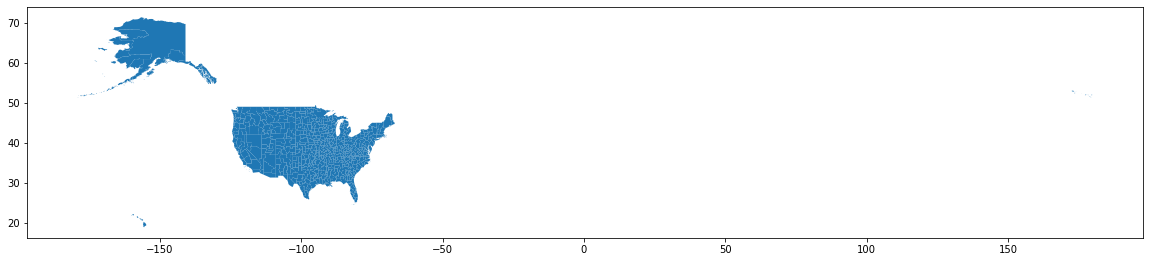

In [75]:
czs.plot( figsize=(20, 20))

In [161]:
# map location to commuting zone
loccz={}
exception = set()
n=0
for yr in ylocsize:
    for loc in ylocsize[yr]:
        if loc not in loccz:
            n+=1
            if n%10000==0:
                flushPrint(n/10000)
            p1 = Point(loc[1], loc[0])
            k=czs[czs['geometry'].contains(p1)]['LM_Code']
            try:
                loccz[loc]=k[k.index[0]]
            except:
                exception.add(loc)

4.0

In [165]:
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/LocCZ.txt', 'w') as f1:
    for loc in loccz:
        locstr = "_".join([str(loc[0]), str(loc[1])])
        line = "\t".join([locstr, str(loccz[loc])])
        f1.write(line + "\n")

In [162]:
len(loccz), len(set(loccz.values())), len(exception)

(46019, 658, 379)

In [164]:
yczsize=defaultdict(lambda:defaultdict(lambda:0))
yidocccz = defaultdict(lambda:defaultdict(lambda:[]))
n=0
for yr in yidoccloc:
    for ind in yidoccloc[yr]:
        n+=1
        if n%100000==0:
            flushPrint(n/100000)
        loc = yidoccloc[yr][ind][1]
        if loc in loccz:
            yidocccz[yr][ind]=(yidoccloc[yr][ind][0], loccz[loc])
            yczsize[yr][loccz[loc]] +=1

393.0

In [170]:
len(yidocccz[2010]), len(yczsize[2010])

(11026378, 658)

In [166]:
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/year_cz_size.txt', 'w') as f1:
    for yr in yczsize:
        for loc in yczsize[yr]:
            size = yczsize[yr][loc]
            line = "\t".join([str(yr),str(loc), str(size)])
            f1.write(line + "\n")

In [167]:
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/year_jobid_cz_occ.txt', 'w') as f1:
    for yr in yidocccz:
        for ind in yidocccz[yr]:
            occ = yidocccz[yr][ind][0]
            loc = yidocccz[yr][ind][1]
            line = "\t".join([str(yr), str(ind), occ, str(loc)])
            f1.write(line + "\n")

In [168]:
thresh={}
thresh[2010]=np.percentile(list(yczsize[2010].values()), [90])[0]
thresh[2018]=np.percentile(list(yczsize[2018].values()), [90])[0]

In [207]:
thresh

{2010: 39041.300000000076, 2018: 83364.70000000007}

In [183]:
sum([yczsize[2010][cz] for cz in yczsize[2010] if yczsize[2010][cz]>=thresh[2010]]) / sum(list(yczsize[2010].values()))

0.7351940954681583

In [184]:
sum([yczsize[2018][cz] for cz in yczsize[2018] if yczsize[2018][cz]>=thresh[2018]]) / sum(list(yczsize[2018].values()))

0.7722782382742412

(array([617.,  17.,   9.,   7.,   0.,   3.,   3.,   0.,   1.,   1.]),
 array([1.000000e+00, 5.512920e+04, 1.102574e+05, 1.653856e+05,
        2.205138e+05, 2.756420e+05, 3.307702e+05, 3.858984e+05,
        4.410266e+05, 4.961548e+05, 5.512830e+05]),
 <BarContainer object of 10 artists>)

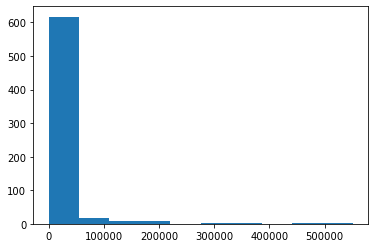

In [176]:
plt.hist(list(yczsize[2010].values()))

(array([616.,  20.,   7.,   9.,   2.,   2.,   1.,   0.,   0.,   1.]),
 array([3.2000000e+01, 1.5770050e+05, 3.1536900e+05, 4.7303750e+05,
        6.3070600e+05, 7.8837450e+05, 9.4604300e+05, 1.1037115e+06,
        1.2613800e+06, 1.4190485e+06, 1.5767170e+06]),
 <BarContainer object of 10 artists>)

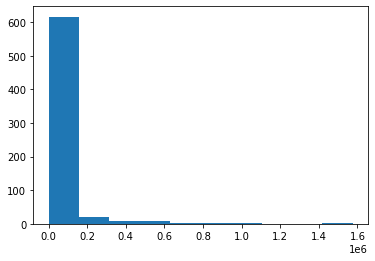

In [185]:
plt.hist(list(yczsize[2018].values()))

In [189]:
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/lcz_occ_year_skill_freq.txt', 'w') as f1:
    pass
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/scz_occ_year_skill_freq.txt', 'w') as f2:
    pass
for yr in [2010, 2018]:   
    # read in the jobid-skill data               
    with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/'+ str(yr) + '/' + str(yr) + '_jobid_date_skill.txt', 'r') as f:
        columns = ['jobid', 'date', "skills"]
        df = pd.read_csv(f, names=columns, delimiter="\t",encoding = "ISO-8859-1") 
        llococc_year_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
        slococc_year_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
        n=0
        for i,j in zip(df['jobid'],df['skills']): 
            if n%100000==0:
                flushPrint(n/100000)
            n+=1
            if i in yidocccz[yr]:
                occ = yidocccz[yr][i][0]
                loc = yidocccz[yr][i][1]
                skills = j.split('_')[:-1]
                if yczsize[yr][loc] > thresh[yr]:
                    for skill in skills:
                        llococc_year_skill_freq[occ][yr][skill]+=1
                else:
                    for skill in skills:
                        slococc_year_skill_freq[occ][yr][skill]+=1
                        
    print(str(yr)+"occupation number: ", len(llococc_year_skill_freq), len(slococc_year_skill_freq))
    
    # save the skill frequency dictionary into txt file
    with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/lcz_occ_year_skill_freq.txt', 'a') as f3:
        for occ in llococc_year_skill_freq:
            for year in llococc_year_skill_freq[occ]:
                skill_freq = "\t".join(["_".join([skill,
                                str(llococc_year_skill_freq[occ][year][skill])]) for skill in llococc_year_skill_freq[occ][year]])
                line = "\t".join([occ, str(year), skill_freq]) 
                f3.write(line + "\n")
    with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/scz_occ_year_skill_freq.txt', 'a') as f4:
        for occ in slococc_year_skill_freq:
            for year in slococc_year_skill_freq[occ]:
                skill_freq = "\t".join(["_".join([skill, 
                                str(slococc_year_skill_freq[occ][year][skill])]) for skill in slococc_year_skill_freq[occ][year]])
                line = "\t".join([occ,str(year), skill_freq]) 
                f4.write(line + "\n")

110.02010occupation number:  825 822
271.02018occupation number:  1056 1047


### Market size by company size

In [193]:
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/lclcz_occ_year_skill_freq.txt', 'w') as f1:
    pass
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/lcscz_occ_year_skill_freq.txt', 'w') as f2:
    pass
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/sclcz_occ_year_skill_freq.txt', 'w') as f3:
    pass
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/scscz_occ_year_skill_freq.txt', 'w') as f4:
    pass

yjcl=defaultdict(lambda:defaultdict(lambda:[]))
for i in [2010, 2018]:
    year = str(i)
    yr=int(year)
    # jobid-company
    JE = {}
    id_job={}
    n = 0
    with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/' + year + '/' + 
              year + '_jobid_employer_occ.txt','r') as f:
        print(year)
        for line in f:
            n+=1
            if n%100000==0:
                flushPrint(n/100000)
            line = line.strip('\n').split('\t')
            jid = int(line[0])
            JE[jid] = line[1]
            id_job[jid] = line[2]         
                
           
    # read in the jobid-skill data               
    with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/'+ year + '/' + year + '_jobid_date_skill.txt', 'r') as f:
        columns = ['jobid', 'date', "skills"]
        df = pd.read_csv(f, names=columns, delimiter="\t",encoding = "ISO-8859-1") 
        lcllococc_year_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
        lcslococc_year_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
        scllococc_year_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
        scslococc_year_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
        for i,j in zip(df['jobid'],df['skills']): 
            if i in JE:
                occ = id_job[i]
                skills = j.split('_')[:-1]
                if i in yidocccz[yr]:
                    loc = yidocccz[yr][i][1]
                    yjcl[yr][i]=[JE[i], loc]
                    if ycsize[yr][JE[i]] > threshcs[yr] and yczsize[yr][loc] > thresh[yr]:
                        for skill in skills:
                            lcllococc_year_skill_freq[occ][yr][skill]+=1
                    elif ycsize[yr][JE[i]] > threshcs[yr] and yczsize[yr][loc] <= thresh[yr]:
                        for skill in skills:
                            lcslococc_year_skill_freq[occ][yr][skill]+=1
                    elif ycsize[yr][JE[i]] <= threshcs[yr] and yczsize[yr][loc] > thresh[yr]:
                        for skill in skills:
                            scllococc_year_skill_freq[occ][yr][skill]+=1
                    else:
                        for skill in skills:
                            scslococc_year_skill_freq[occ][yr][skill]+=1

    
    #save the skill frequency dictionary into txt file
    with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/lclcz_occ_year_skill_freq.txt', 'a') as f1:
        for occ in lcllococc_year_skill_freq:
            for yr in lcllococc_year_skill_freq[occ]:
                skill_freq = "\t".join(["_".join([skill,
                                str(lcllococc_year_skill_freq[occ][yr][skill
                                                ])]) for skill in lcllococc_year_skill_freq[occ][yr]])
                line = "\t".join([occ, str(yr), skill_freq]) 
                f1.write(line + "\n")
    with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/lcscz_occ_year_skill_freq.txt', 'a') as f2:
        for occ in lcslococc_year_skill_freq:
            for yr in lcslococc_year_skill_freq[occ]:
                skill_freq = "\t".join(["_".join([skill,
                                str(lcslococc_year_skill_freq[occ][yr][skill
                                                ])]) for skill in lcslococc_year_skill_freq[occ][yr]])
                line = "\t".join([occ, str(yr), skill_freq]) 
                f2.write(line + "\n")
    with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/sclcz_occ_year_skill_freq.txt', 'a') as f3:
        for occ in scllococc_year_skill_freq:
            for yr in scllococc_year_skill_freq[occ]:
                skill_freq = "\t".join(["_".join([skill, 
                                str(scllococc_year_skill_freq[occ][yr][skill
                                                ])]) for skill in scllococc_year_skill_freq[occ][yr]])
                line = "\t".join([occ, str(yr), skill_freq]) 
                f3.write(line + "\n")
    with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/scscz_occ_year_skill_freq.txt', 'a') as f4:
        for occ in scslococc_year_skill_freq:
            for yr in scslococc_year_skill_freq[occ]:
                skill_freq = "\t".join(["_".join([skill, 
                                str(scslococc_year_skill_freq[occ][yr][skill
                                                ])]) for skill in scslococc_year_skill_freq[occ][yr]])
                line = "\t".join([occ, str(yr), skill_freq]) 
                f4.write(line + "\n")

2010
64.02018
216.0

In [194]:
yjcl=defaultdict(lambda:defaultdict(lambda:[]))
for i in [2010, 2018]:
    year = str(i)
    yr=int(year)
    # jobid-company
    JE = {}
    id_job={}
    n = 0
    with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/' + year + '/' + 
              year + '_jobid_employer_occ.txt','r') as f:
        print(year)
        for line in f:
            n+=1
            if n%100000==0:
                flushPrint(n/100000)
            line = line.strip('\n').split('\t')
            jid = int(line[0])
            JE[jid] = line[1]
            id_job[jid] = line[2]         
                
           
    # read in the jobid-skill data               
    with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/'+ year + '/' + year + '_jobid_date_skill.txt', 'r') as f:
        columns = ['jobid', 'date', "skills"]
        df = pd.read_csv(f, names=columns, delimiter="\t",encoding = "ISO-8859-1") 
        for i,j in zip(df['jobid'],df['skills']): 
            if i in JE:
                occ = id_job[i]
                skills = j.split('_')[:-1]
                if i in yidocccz[yr]:
                    loc = yidocccz[yr][i][1]
                    yjcl[yr][i]=[JE[i], loc]

2010
64.02018
216.0

In [195]:
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/year_jobid_comp_cz.txt', 'w') as f1:
    for yr in yjcl:
        for ind in yjcl[yr]:
            comp = yjcl[yr][ind][0]
            loc = str(yjcl[yr][ind][1])
            line = "\t".join([str(yr), str(ind), comp, loc])
            f1.write(line + "\n")

In [196]:
# employer concentration
LocYOccEmpNpost=defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0))))
for yr in yjcl:
    n=0
    with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/' + str(yr) + '/' + 
              str(yr) + '_jobid_employer_occ.txt','r') as f:
        print(yr)
        for line in f:
            n+=1
            if n%100000==0:
                flushPrint(n/100000)
            line = line.strip('\n').split('\t')
            jid = int(line[0])
            id_job[jid] = line[2]
    k=0     
    for ind in yjcl[yr]:
        k+=1
        if k%100000==0:
            flushPrint(k/100000)
        comp = yjcl[yr][ind][0]
        loc = yjcl[yr][ind][1]
        LocYOccEmpNpost[loc][yr][id_job[ind]][comp] += 1        

2010
59.02018
198.0

In [197]:
len(LocYOccEmpNpost)

658

In [200]:
YOccLocEC=defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for loc in LocYOccEmpNpost:
    for yr in LocYOccEmpNpost[loc]:
        for occ in LocYOccEmpNpost[loc][yr]:
            jsum=np.sum(list(LocYOccEmpNpost[loc][yr][occ].values()))
            YOccLocEC[yr][occ][loc] = np.sum(
                [(LocYOccEmpNpost[loc][yr][occ][emp] / jsum)**2 for emp in LocYOccEmpNpost[loc][yr][occ]])

In [201]:
len(YOccLocEC[2010]), len(YOccLocEC[2018])

(820, 832)

In [202]:
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/year_occ_cz_empcon.txt', 'w') as f1:
    for yr in YOccLocEC:
        for occ in YOccLocEC[yr]:
            for loc in YOccLocEC[yr][occ]:
                line = "\t".join([str(yr), str(occ), str(loc), str(YOccLocEC[yr][occ][loc])])
                f1.write(line + "\n")

In [203]:
Lloc_YOCCEC=defaultdict(lambda:defaultdict(lambda: []))
Sloc_YOCCEC=defaultdict(lambda:defaultdict(lambda: []))
for yr in YOccLocEC:
    for occ in YOccLocEC[yr]:
        for loc in YOccLocEC[yr][occ]:
            if yczsize[yr][loc] > thresh[yr]:
                Lloc_YOCCEC[yr][occ].append(YOccLocEC[yr][occ][loc])
            else:
                Sloc_YOCCEC[yr][occ].append(YOccLocEC[yr][occ][loc])  
        Lloc_YOCCEC[yr][occ]=np.mean(Lloc_YOCCEC[yr][occ])
        Sloc_YOCCEC[yr][occ]=np.mean(Sloc_YOCCEC[yr][occ])
        
    Lloc_YOCCEC[yr]=dict(sorted(Lloc_YOCCEC[yr].items(), key=operator.itemgetter(1), reverse=True))
    Sloc_YOCCEC[yr]=dict(sorted(Sloc_YOCCEC[yr].items(), key=operator.itemgetter(1), reverse=True))

C:\Users\ditong\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ditong\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [204]:
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/LLOCyear_occ_empcon.txt', 'w') as f1:
    for yr in Lloc_YOCCEC:
        for occ in Lloc_YOCCEC[yr]:
            line = "\t".join([str(yr), str(occ), str(Lloc_YOCCEC[yr][occ])])
            f1.write(line + "\n")

with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/SLOCyear_occ_empcon.txt', 'w') as f1:
    for yr in Sloc_YOCCEC:
        for occ in Sloc_YOCCEC[yr]:
            line = "\t".join([str(yr), str(occ), str(Sloc_YOCCEC[yr][occ])])
            f1.write(line + "\n")

### 4. year - socName - skill freq

#### Extract 10 * Year: jobid, year, skill from Raw Skill Data

In [ ]:
start = time.clock()
for i in range(2010, 2020):
    year = str(i)
    with open('/project2/jevans/ditong/data/SOC/'+ year + '/' + year + '_jobid_date_skill.txt', 'w') as f:
        pass
    folder = '/project2/jevans/BG/Structured_Data/Skill_zip/' + year + '/'
    for f in listdir(folder):
        if not f.startswith('.'):
            print(f)
            with ZipFile(folder+f) as z:
                with z.open(f.split('.')[0]+'.txt') as f1:
                    df = pd.read_csv(f1,header='infer',delimiter="\t",encoding = "ISO-8859-1")
                    filtered_dic = defaultdict(lambda:defaultdict(lambda:''))
                    for i,j,k in zip(df['BGTJobId'],df['JobDate'],df['Skill']): 
                        if k != 'na':
                            filtered_dic[i][j]=filtered_dic[i][j] +  k + '_'
            with open('/project2/jevans/ditong/data/SOC/'+ year + '/' + year + '_jobid_date_skill.txt', 'a') as f:
                for jobid in filtered_dic:
                    for date in filtered_dic[jobid]:
                        skill = filtered_dic[jobid][date]
                        line = "\t".join([str(jobid), date, skill]) 
                        f.write(line + "\n")
                    
elapsed = (time.clock() - start)  

#### Calculate Year - SOCName - Skill Frequency

In [ ]:
for i in range(2010, 2020):
    year = str(i)
    # read in the jobid-occupation name data
    dic_id_job = {}
    with open('/project2/jevans/ditong/data/SOC/' + year + '/' + 
              year + '_job_id.txt','r') as f:
        for line in f:
            if line != '\n':
                line_lst = line[:-1].split('\t')
                job = line_lst[0]
                ids = line_lst[1].split("_")
                for jobid in ids:
                    dic_id_job[int(jobid)] = job
                    
    # read in the jobid-skill data               
    with open('/project2/jevans/ditong/data/SOC/'+ year + '/' + year + '_jobid_date_skill.txt', 'r') as f:
        print(f)
        columns = ['jobid', 'date', "skills"]
        df = pd.read_csv(f, names=columns, delimiter="\t",encoding = "ISO-8859-1") 
        occ_skill_freq = defaultdict(lambda:defaultdict(lambda:0))
        skill_occnum = defaultdict(lambda:set())
        for i,j in zip(df['jobid'],df['skills']): 
            if i in dic_id_job:
                occ = dic_id_job[i]
                skills = j.split('_')[:-1]
                for skill in skills:
                    occ_skill_freq[occ][skill]+=1
                    skill_occnum[skill].add(occ)
    print(len(occ_skill_freq), len(skill_occnum))
    
    # save the skill frequency dictionary into txt file
    with open('/project2/jevans/ditong/data/SOC/'+ year + '/' + year + '_occ_skill_freq.txt', 'w') as f:
        for occ in occ_skill_freq:
            skill_freq = "\t".join(["_".join([skill, str(occ_skill_freq[occ][skill])]) for skill in occ_skill_freq[occ]])
            line = "\t".join([occ, skill_freq]) 
            f.write(line + "\n")
    
    
#     # calculate the tf-idf score for each skill for each occupation, store in dicationary
#     occ_skill_tfidf = defaultdict(lambda:defaultdict(lambda:0))
#     for occ in occ_skill_freq:
#         for skill in occ_skill_freq[occ]:
#             occ_skill_tfidf[occ][skill] = (occ_skill_freq[occ][skill] / len(occ_skill_freq[occ])) * math.log(len(occ_skill_freq) / len(skill_occnum[skill]))
#     # sort the skills for each occupation by tf-idf value
#     for occ in occ_skill_tfidf:
#         sorted_dic = dict(sorted(occ_skill_tfidf[occ].items(), key=operator.itemgetter(1), reverse=True))
#         occ_skill_tfidf[occ] = sorted_dic
#     # save the dictionary into txt file
#     with open('/project2/jevans/ditong/data/SOC/'+ year + '/' + year + '_occ_skill_tfidf.txt', 'w') as f:
#         for occ in occ_skill_tfidf:
#             skill_idf = "\t".join(["_".join([skill, str(occ_skill_tfidf[occ][skill])]) for skill in occ_skill_tfidf[occ]])
#             line = "\t".join([occ, skill_idf]) 
#             f.write(line + "\n")

In [ ]:
# Put all Years in One file
with open ('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/occ_year_skill_freq.txt', 'w') as f:
    for i in range(2010, 2020):
        year = str(i)
        with open('/project2/jevans/ditong/data/SOC/'+ year + '/' + year + '_occ_skill_freq.txt', 'r') as f1:
            for line in f1:
                if line != '\n':
                    line_lst = line.split("\t")
                    occ = line_lst[0]
                    skills = line_lst[1:]
                    newline = "\t".join([occ, year]+skills)
                    f.write(newline)

### 5. Replication of Deming and Noray's (2020) Skill Change Measurement

In [ ]:
# for replicating Deming and Noray's measurement: use sample with non missing employer and MSA

# sample with non-missing employer and MSA
# prepare and save data: occupation - year - skill - frequency; occupation - year - npost; occupation - year - sum skill frequency
occ_y_sfreq = defaultdict(lambda:defaultdict(lambda:0))
occ_y_freq = defaultdict(lambda:defaultdict(lambda:0))
occ_y_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))

for year in ['2007', '2019', '2010', '2018']:
    dic_id_job = {}
    # read in the jobid-occupation name data
    if year in ['2007', '2019']:
        path = '/Users/ditong/Dropbox (MIT)/skills/Data/raw/' + year + '_jobid_employer_occ.txt'
    elif year in ['2010', '2018']:
        path = '/Users/ditong/Dropbox (MIT)/skills/Data/raw/' + year + '/' + year + '_jobid_employer_occ.txt'
        
    with open(path,'r') as f:
        n=0
        for line in f:
            if line != '\n':
                n+=1
                if n%100000 == 0:
                    flushPrint(n/100000)
                line_lst = line.strip('\n').split('\t')
                dic_id_job[int(line_lst[0])] = line_lst[2]
                
    
    print(year, ": ", len(dic_id_job))
    
    # read in the jobid-skill data               
    with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/' + year + '/' + year + '_jobid_date_skill.txt', 'r') as f:
        columns = ['jobid', 'date', "skills"]
        df = pd.read_csv(f, names=columns, delimiter="\t",encoding = "ISO-8859-1", low_memory=False) 
        m=0
        for i,j in zip(df['jobid'],df['skills']): 
            m+=1
            if m%100000 == 0:
                flushPrint(m/100000)
            if i in dic_id_job:
                occ = dic_id_job[i]
                skills = j.split('_')[:-1]
                for s in skills:
                    occ_y_sfreq[occ][year]+=1
                    occ_y_skill_freq[occ][year][s]+=1
                occ_y_freq[occ][year]+=1

print(len(occ_y_sfreq), len(occ_y_freq))

# save data
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_skill_freq_emp.txt', 'w') as f:
    for occ in occ_y_skill_freq:
        for year in occ_y_skill_freq[occ]:
            sfreqs = []
            for s in occ_y_skill_freq[occ][year]:
                sfreqs.append("_".join([s, str(occ_y_skill_freq[occ][year][s])]))
            line = "\t".join([occ, year] + sfreqs)
            f.write(line + '\n')
            
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_npost_emp.txt', 'w') as f:
    for occ in occ_y_freq:
        for year in occ_y_freq[occ]:
            line = "\t".join([occ, year, str(occ_y_freq[occ][year])])
            f.write(line + '\n')

In [ ]:
# calculate job skill change and save data
# weights
jw1 = {}
for j in occ_y_sfreq:
    if j in occ_y_freq:
        if '2010' in occ_y_sfreq[j] and '2018' in occ_y_sfreq[j]:
            jw1[j] = (occ_y_sfreq[j]['2010'] / occ_y_sfreq[j]['2018']) / (occ_y_freq[j]['2010']/occ_y_freq[j]['2018'])
            if jw1[j] > 1:
                jw1[j] = 1
                
jw2 = {}
for j in occ_y_sfreq:
    if j in occ_y_freq:
        if '2007' in occ_y_sfreq[j] and '2019' in occ_y_sfreq[j]:
            jw2[j] = (occ_y_sfreq[j]['2007'] / occ_y_sfreq[j]['2019']) / (occ_y_freq[j]['2007']/occ_y_freq[j]['2019'])
            if jw2[j] > 1:
                jw2[j] = 1
                
# skill probability
jyspro = copy.deepcopy(occ_y_skill_freq)
for j in jyspro:
    for y in jyspro[j]:
        for s in jyspro[j][y].keys():
            jyspro[j][y][s] = jyspro[j][y][s]/occ_y_freq[j][y]
            
# job change
jyc = defaultdict(lambda:defaultdict(lambda:0))
occsc79=defaultdict(lambda:0)
occsc80=defaultdict(lambda:0)
for j in jyspro:
    if '2007' in jyspro[j] and '2019' in jyspro[j]:
        # get the union of skills of 2 years
        alls = set(jyspro[j]['2007'].keys()).union(set(jyspro[j]['2019'].keys()))
        # skill probability change
        for s in alls:
            jyc[j]['07-19'] += abs(jyspro[j]['2019'][s] - jyspro[j]['2007'][s])
        jyc[j]['07-19'] = jyc[j]['07-19']*jw2[j]
        occsc79[j] = jyc[j]['07-19']
            
    if '2010' in jyspro[j] and '2018' in jyspro[j]:
        # get the union of skills of 2 years
        alls = set(jyspro[j]['2010'].keys()).union(set(jyspro[j]['2018'].keys()))
        # skill probability change
        for s in alls:
            jyc[j]['10-18'] += abs(jyspro[j]['2018'][s] - jyspro[j]['2010'][s])
        jyc[j]['10-18'] = jyc[j]['10-18']*jw1[j]
        occsc80[j] = jyc[j]['10-18']
        
# save 
df79 = pd.DataFrame()
sorted79 =  dict(sorted(occsc79.items(), key=operator.itemgetter(1), reverse=True))
df79['SOC'] = list(sorted79.keys())
df79["SkillChange"] = list(sorted79.values())
df79.to_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/0719Soc6SkillChange_emp.csv')

df80 = pd.DataFrame()
sorted80 =  dict(sorted(occsc80.items(), key=operator.itemgetter(1), reverse=True))
df80['SOC'] = list(sorted80.keys())
df80["SkillChange"] = list(sorted80.values())
df80.to_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/1018Soc6SkillChange_emp.csv')

###  6. skill pair PMI calculation for network building

In [ ]:
# skill-occupation-frequency dict
skillof = defaultdict(lambda:defaultdict(lambda:'na'))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        year = int(line_lst[1])
        if year == 2010:
            job = line_lst[0]
            skills = line_lst[2:]
            for skill_freq in skills:
                skill = skill_freq.split('_')[0].lower()
                if skill in oskill[job]:
                    freq = int(skill_freq.split('_')[1])
                    skillof[skill][job] = freq

In [ ]:
# change skill name into skill indices, create mapping dict
# create occupation-skill-frequency, skill-occupation-frequency and occupation-skill list dicts with skill indices 
s_id_n = {}
osf = defaultdict(lambda:defaultdict(lambda:'na'))
sof = defaultdict(lambda:defaultdict(lambda:'na'))
os = defaultdict(lambda:[])
n=0
for s in skillof:
    s_id_n[n] = s
    for o in skillof[s]:
        os[o].append(n)
        osf[o][n] = skillof[s][o]
        sof[n][o] = skillof[s][o]
    n+=1

In [ ]:
# save the skill name-indices dictionary
with open('/Users/ditong/Documents/large scale computing/final-project-di-Tong/2010_skill_id_name.json', 'w') as fp:
    json.dump(s_id_n, fp)

In [ ]:
# Function to call a AWS Lambda function to find skill pairs co-occuring in the same occupation 
# for a subset of occupations
def find_skill_pairs(lsts_occs_skills):
    '''
    Input: 
        lsts_occs_skills: a list of lists--a list of occupations, each as a skill list
    
    Returns:
        sets of co-occuring skill pairs (skill1, skill2)
    
    '''
    
    skill_pair_set = set()
    # input (list of list): a list of occupations, each as a skill list
    for lst_skills in lsts_occs_skills:
        # get all pairs in each skill list
        skill_pairs = [(lst_skills[i],lst_skills[j]) for i in range(len(lst_skills)) 
                   for j in range(i+1, len(lst_skills))]
        # sort the pairs to filter out duplicates in the merging process
        sorted_pairs = [tuple(sorted(p)) for p in skill_pairs]
        # merge the resulting pairs across all the occupations
        skill_pair_set = skill_pair_set.union(set(sorted_pairs))
          
    return skill_pair_set

In [ ]:
# let each aws lambda function find co-occuring skill pairs in a subset of 40 occupations
lsts_skills = list(os.values())
split = [lsts_skills[x:x+40] for x in range(0, len(lsts_skills), 40)]
# Set up a pywren executor and find co-occuring skill pairs
pwex = pywren.default_executor()
skill_pairs = pywren.get_all_results(pwex.map(find_skill_pairs, split))

# merge all skill pairs into one list (duplicates deleted in process)
sp = set()
n=0
for skill_pair in skill_pairs:
    n+=1
    flushPrint(n)
    sp = sp.union(skill_pair)
sp=list(sp)

In [ ]:
# prepare data: sum frequncy for all skills for all occupation; occupation-probablity dict
sum_freq = sum([sum(v.values()) for k,v in osf.items()])
oprob = {}
for occ in osf:
    sum_occ_freq = sum(osf[occ].values())
    oprob[occ] = sum_occ_freq / sum_freq

In [ ]:
# Function to call a AWS Lambda function to calculate skill pairs PMI for a subset of skill pairs
def calculate_sp_pmi(lst_pairs, sof, oprob, sum_freq):
    '''
    Input: 
        lst_pairs: a list of skill pairs (in tuple)
        sof: skill-occupation-frequency dictionary
        oprob: occupation-probability dictionary
        sum_freq: the sum of frequncy for all skills in all occupations (the sum of all values in sof)
    
    Formula:
    skill pair (i, j)'s PMI<i, j> = log(P<i,j> / (Pi * Pj))
    P<i,j> = sum (P<i|c> * P<j|c> * Pc) for all occupations c
    P<i|c> = P<i,c> / Pc
    P<i,c> = Freq<i,c> / sum_freq
    Pi = Freq<i> / sum_freq
    
    Returns:
        lists of (skill1, skill2, PMI)
    
    '''
    
    import numpy as np
    
    pair_pmi = []
    for i,j in lst_pairs:
        if i in sof and j in sof:
            pij = 0
            # find the occupations that i and j are co-occuring
            occs = set(sof[i].keys()).intersection(set(sof[j].keys()))
            for occ in occs:
                # check if the occupation has a probability value
                if occ in oprob:
                    # i and j's co-occuring probability in each occupation weighted by occupation's probability
                    pijc = (sof[i][occ] / sum_freq) * (sof[j][occ] / sum_freq) / oprob[occ]
                    # sum up i and j's weighted co-occuring probabilities in all occupations
                    pij += pijc
            # skill i 's probability
            pi = sum(sof[i].values()) / sum_freq
            # skill j 's probability
            pj = sum(sof[j].values()) / sum_freq
            # pmi-skill i and j
            pmi_ij = np.log(pij / (pi * pj))
            pair_pmi.append((i, j, pmi_ij))
                   
    return pair_pmi

In [ ]:
# split the data into chunks with 50000 skill pairs each 
# ( I found after trials that each pywren call could not execute more data than this on my task)
splits = [sp[x:x+50000] for x in range(0, len(sp), 50000)]
# set up am empty list to merge returned data from each pywren call
sp_pmis = []
# set up an empty file to write in data returned from each pywren call
with open('./skillpair_pmi.txt', 'w') as f:
    pass
# call pywren to Calculate Pairwise Skill Pmi for each chunk of data
n=0
for splitk in splits[180:]:
    # let each aws lambda function Calculate Pairwise Skill Pmi for a subset of 50 skill pairs
    split = [splitk[x:x+50] for x in range(0, len(splitk), 50)]
    # Set up a pywren executor
    pwex = pywren.default_executor()
    sp_pmi = pywren.get_all_results(pwex.map(lambda x: calculate_sp_pmi(x, sof, oprob, sum_freq), split))
    sp_pmis += sp_pmi
    with open('./skillpair_pmi.txt', 'a') as f:
        for sppmi in sp_pmi:
            for i, j, pmi in sppmi:
                line = "\t".join([str(i), str(j), str(pmi)])
                f.write(line + "\n")
    flushPrint(n)
    n+=1

### 7. skill embedding (all years)

#### Extract from Raw Skill Data: 10 * Year Skill Co-occurence

In [2]:
def extract_skill(gr): 
    cleaned_gr = [element.lower() for element in gr if element != 'na']
    cleaned_gr = list(set(cleaned_gr))
    skills = '\t'.join(cleaned_gr)
    return skills

In [ ]:
def pre_process(df, f1):
    grouped = df.groupby('BGTJobId')['Skill'].apply(extract_skill)
    skills = []
    seed = 0
    for job in grouped:
        seed += 1
        skill_lst = job.split('\t')
        if skill_lst != ['']:
            if len(skill_lst) > 2:
                final_lst = list(permutation(skill_lst))
            else:
                final_lst = skill_lst
            line = "\t".join(final_lst)
            f1.write(line + "\n")

In [ ]:
for year in range(2018, 2020):
    start = time.clock()
    print(year)
    with open('/project2/jevans/ditong/skill_embed_imput/' + str(year) + '_skills.txt','wb') as f1:
        folder='/project2/jevans/BG/Structured Data/Skill/'+str(year)+'/'
        for f in listdir(folder):
            if not f.startswith('.'):
                print(f)
                with ZipFile(folder+f) as z:
                    with z.open(f.split('.')[0]+'.txt') as f:
                        df = pd.read_csv(f,header='infer',delimiter="\t",encoding = "ISO-8859-1")
                        pre_process(df, f1)
        elapsed = (time.clock() - start)
        print(elapsed/60)

#### Produce Skill Embedding Model

In [ ]:
# data streaming to prepare for imput
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            with open(self.dirname + fname,'r') as f:
                for line in f:
                    yield line[:-1].split('\t')
sentences = MySentences('/project2/jevans/ditong/skill_embed_imput/')

In [ ]:
# only include skills with at least 10 occurences; vector dimension 200; window size 300 to be larger than
# the largest skill number required in one post; 
start = time.clock()
model_1 = Word2Vec(sentences, min_count=10,size= 200, workers=8, window=300, sg = 1, negative=5, compute_loss=True)
elapsed = (time.clock() - start)
model_1.get_latest_training_loss()
model_1.save("/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/w2v_m10_s200_w300_sg1_n5.model")

### 8. skill atoms

In [ ]:
def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='/Users/ditong/Dropbox (MIT)/skills/atom_model/'): 
    #set for Alina's files, switch to where you want save the model
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) 
    #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 
    #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. 
    #transform_n is the number of atoms (components) that a word can be a linear combo of
    
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ 
    #Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) 
    #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

In [ ]:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error



In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)

def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)



#### determine the hyperparameter: number of atoms

In [ ]:
res = {}
for i in range(50,500,10):
    dictionary, alpha = do_aksvd(model, i, 5, save=False)
    td = topic_diversity(model, dictionary, top_n=25)
    sse3, rmse, r2 = reconst_qual(model, dictionary, alpha)
    res[i] = (td,r2)
    print(i,res[i])

In [ ]:
x = list(res.keys())
y = [res[i][0]*res[i][1] for i in res]
plt.plot(x,y)

In [ ]:
dictionary, alpha = do_aksvd(model, 210, 5, save=True)
td = topic_diversity(model, dictionary, top_n=25)
_,_,r2 = reconst_qual(model, dictionary, alpha)
#td*r2=0.5825234592261156

### 9. Re-education cost

In [ ]:
# all data, 200 dimensions, 300 window, skipgram, negative sampling 5, word occurence > 10
model = Word2Vec.load("/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/w2v_m10_s200_w300_sg1_n5.model")

#### Take random sample from 2010 full year data

In [ ]:
# soc and edu: randomly pick 1/10: randomly pick 10%
random.seed(114)
#random.seed(821)
#random.seed(666)
jsocedu={}
with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/2010/2010_jobid_soc_minedu.txt', 'r') as f:
    for line in f:
        if random.random() < 0.1:
            line_lst = line[:-1].split('\t')
            jsocedu[int(line_lst[0])] = [line_lst[1], float(line_lst[2])]

In [ ]:
# skills
start = time.perf_counter()
jslst = {}
jsn = {}
socsnj = defaultdict(lambda:defaultdict(lambda:[]))
n=0
with open('/Users/ditong/Dropbox (MIT)/skills/Data/raw/2010/2010_jobid_date_skill.txt', 'r') as f:
    for line in f:
        n+=1
        if n>1000000 and n % 1000000 == 0:
            flushPrint(n/1000000)
        line_lst = line[:-1].split('\t')
        if line_lst[0] != '"jobid"':
            jid = int(line_lst[0])
            if jid in jsocedu:
                jslst[jid] = line_lst[2].strip('"').split('_')[:-1]
                jsn[jid] = len(jslst[jid])
                soc = jsocedu[jid][0]
                socsnj[soc][jsn[jid]].append(jid)
elapsed = (time.perf_counter() - start) 

In [ ]:
fullsocs = defaultdict(lambda:0)
for occ in socsnj:
    for sn in socsnj[occ]:
        fullsocs[occ]+=len(socsnj[occ][sn])

#### Taking full sample from a random month

In [ ]:
jsoceduexp={}
with open ('/Users/ditong/Dropbox (MIT)/skills/skillProject/BG_minidata/BG_2010/structured/Main_2010-07.txt', 'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        if line_lst[0] != '"BGTJobId"' and line_lst[8]!='"na"' and int(line_lst[37].strip('"')) >0:
            jsoceduexp[int(line_lst[0])] = [line_lst[8].strip('"'), float(line_lst[37].strip('"')), float(line_lst[41].strip('"'))]

In [ ]:
jidslst = defaultdict(lambda:[])
with open ('/Users/ditong/Dropbox (MIT)/skills/skillProject/BG_minidata/BG_2010/structured/Skills_2010-07.txt', 'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        if line_lst[0] != '"BGTJobId"' and line_lst[2]!='"na"':
            if int(line_lst[0]) in jsoceduexp:
                jidslst[int(line_lst[0])].append(line_lst[2].strip('"'))

In [ ]:
jsn = {}
socsnj = defaultdict(lambda:defaultdict(lambda:[]))
for j in jidslst:
    jsn[j] = len(jidslst[j])
    socsnj[jsoceduexp[j][0]][jsn[j]].append(j)

#### Finding pairs

In [ ]:
# finding pairs
def uniquecombo(socsnj, occ, sn, jsoceduexp, ind, jslst):
    
    unique1 = defaultdict(lambda:0)
    for j in socsnj[occ][sn]:
        unit = tuple([jsoceduexp[j][ind]]+sorted(jslst[j]))
        unique1[unit] += 1
        
    return unique1
def skillvecdiff(j1, j2):
    
    j1vec = np.mean([model.wv[s.lower()] for s in j1],axis=0)
    j2vec = np.mean([model.wv[s.lower()] for s in j2],axis=0)
    skilldiff = 1- np.dot(j1vec, j2vec)/(np.linalg.norm(j1vec)* np.linalg.norm(j2vec))
    
    return skilldiff
def findpair(unique1, unique2):
    allpairs = []
    for u1 in unique1:
        for u2 in unique2:
            if set(list(u1)[1:]).issubset(list(u2)[1:]) and all(s.lower() in model.wv for s in list(u2)[1:]):
                edud = u2[0] - u1[0]
                svd = skillvecdiff(list(u1)[1:], list(u2)[1:])
                maxd, maxmd, avgmaxmd = maxskillvecdiff(list(u1)[1:], list(u2)[1:])
                for i in range(unique1[u1]*unique2[u2]):
                    allpairs.append([edud, svd, maxd, maxmd, avgmaxmd, u1[0], u2[0]])           
                    
    return allpairs

In [ ]:
# all skill number and added skill number, positive edu change skill n
# n+1 and m+1 to be the real skill number
SocSmSnEdudSvd = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:[])))
a=0
for occ in socsnj:
    a+=1
    flushPrint(a)
    sns = sorted(socsnj[occ].keys())
    for m in range(len(sns)-1):
        unique1 = uniquecombo(socsnj, occ, sns[m], jsocedu, 1,jslst)
        for n in range(m+1, len(sns)):
            unique2 = uniquecombo(socsnj, occ, sns[n], jsocedu, 1, jslst)
            allpairs = findpair(unique1, unique2)
            if allpairs:
                SocSmSnEdudSvd[occ][m][n]=allpairs

In [ ]:
# 2010 random 10%, seed 114
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/SocSnSaddEdudSvd_10perc114seed.txt', 'w') as f:
    for occ in SocSmSnEdudSvd:
        for m in SocSmSnEdudSvd[occ]:
            for n in SocSmSnEdudSvd[occ][m]:
                for unit in SocSmSnEdudSvd[occ][m][n]:
                    line="\t".join([occ, str(m), str(n)]+[str(u) for u in unit])
                    f.write(line+'\n')
# 2010 random 10%, seed 666, 821   

# 2010 July
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/SocSnSaddEdudSvd_July.txt', 'w') as f:
    for occ in SocSmSnEdudSvd:
        for m in SocSmSnEdudSvd[occ]:
            for n in SocSmSnEdudSvd[occ][m]:
                for unit in SocSmSnEdudSvd[occ][m][n]:
                    line="\t".join([occ, str(m), str(n)]+[str(u) for u in unit])
                    f.write(line+'\n')
# 2010 March, Jan, Nov